In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
#reading from pickle
with open('processed_df_final.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60434 entries, 0 to 65868
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          60434 non-null  object 
 1   album_name        60434 non-null  object 
 2   artists           60434 non-null  object 
 3   track_name        60434 non-null  object 
 4   track_genre       60434 non-null  object 
 5   duration_ms       60434 non-null  int64  
 6   explicit          60434 non-null  int64  
 7   href              60434 non-null  object 
 8   danceability      60434 non-null  float64
 9   energy            60434 non-null  float64
 10  loudness          60434 non-null  float64
 11  mode              60434 non-null  int64  
 12  speechiness       60434 non-null  float64
 13  acousticness      60434 non-null  float64
 14  instrumentalness  60434 non-null  float64
 15  liveness          60434 non-null  float64
 16  valence           60434 non-null  float6

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [ ]:
df_vect = df.copy()

In [ ]:
# creating a custom tokenizer that will only split words based on white space since multi-word genres 
# are formatted with dashes (-) to between the words
def my_tokenizer(text):
    # Split text into tokens based on whitespace characters
    tokens = re.split(r'\s+', text)
    return tokens

In [ ]:
bagofwords = CountVectorizer(tokenizer=my_tokenizer).fit(df_vect['track_genre'])

In [ ]:
transformed = bagofwords.transform(df_vect['track_genre'])

In [4]:
vect_matrix = pd.DataFrame(columns=bagofwords.get_feature_names(), data=transformed.toarray())
vect_matrix.head()

In [ ]:
df_vect = pd.concat([df_vect.reset_index(),vect_matrix],axis=1)

In [ ]:
df_vect['popularity'] = np.where(df_vect['popularity'] >= np.median(df_vect['popularity']), 1, 0)

In [ ]:
df_vect.info()

In [10]:
vect_rem, vect_test = train_test_split(df_vect, test_size=0.25, random_state=42,
                                     stratify=df_vect[['track_genre','popularity']])

### Train and validation checking

In [14]:
vect_train, vect_validation = train_test_split(vect_rem, test_size=0.25, random_state=42,
                                     stratify=vect_rem[['track_genre','popularity']])

In [16]:
X_train = vect_train.drop(columns='popularity')
y_train = vect_train['popularity']
X_val = vect_validation.drop(columns='popularity')
y_val = vect_validation['popularity']

In [18]:
X_train.drop(columns=['track_id', 'album_name', 'artists', 'track_name', 'track_genre',
       'href', 'preview_url'],inplace=True)
X_val.drop(columns=['track_id', 'album_name', 'artists', 'track_name', 'track_genre',
       'href', 'preview_url'],inplace=True)

In [19]:
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_val_ss = scaler.transform(X_val)

In [55]:
#X_rem = vect_train.drop(columns='popularity')
#y_rem = vect_train['popularity']
#X_test = vect_test.drop(columns='popularity')
#y_test = vect_test['popularity']

In [26]:
train_acc = []
val_acc = []
for x in [0.3,0.35,0.4,0.45,0.5,0.55,0.6]:
    xgb = XGBClassifier(learning_rate=x).fit(X_train_ss,y_train)
    train_acc.append(accuracy_score(xgb.predict(X_train_ss),y_train))
    val_acc.append(accuracy_score(xgb.predict(X_val_ss),y_val))

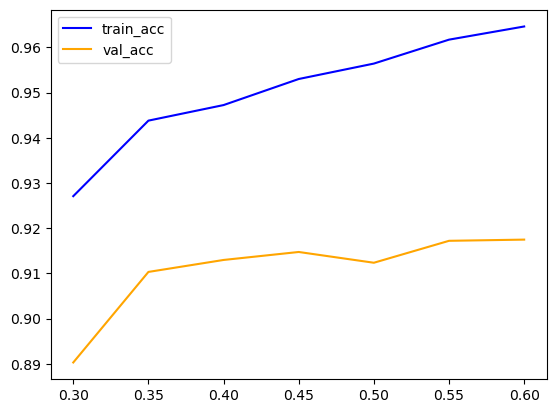

In [28]:
plt.figure()
plt.plot([0.3,0.35,0.4,0.45,0.5,0.55,0.6], train_acc, color='blue', label='train_acc')
plt.plot([0.3,0.35,0.4,0.45,0.5,0.55,0.6], val_acc, color='orange', label='val_acc')
plt.legend()
plt.show()

In [29]:
train_acc = []
val_acc = []
for x in [0.5,0.55,0.6,0.65,0.7]:
    xgb = XGBClassifier(learning_rate=x).fit(X_train_ss,y_train)
    train_acc.append(accuracy_score(xgb.predict(X_train_ss),y_train))
    val_acc.append(accuracy_score(xgb.predict(X_val_ss),y_val))

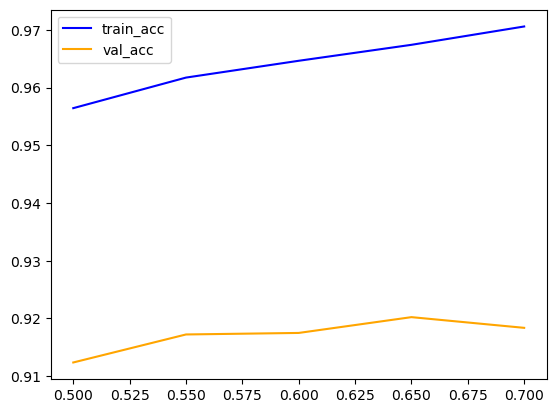

In [30]:
plt.figure()
plt.plot([0.5,0.55,0.6,0.65,0.7], train_acc, color='blue', label='train_acc')
plt.plot([0.5,0.55,0.6,0.65,0.7], val_acc, color='orange', label='val_acc')
plt.legend()
plt.show()

### Grid Search

In [20]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])

# parameters
params = {
    #'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.05, 0.1, 0.3],
    'xgb__n_estimators': [50,100],
    'xgb__gamma':[0, 0.1, 0.2],
   # 'xgb__subsample': [0.5, 0.7, 0.9], for overfitting purposes
   # 'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=4)
grid.fit(X_train_ss, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                  

In [21]:
grid.best_score_

0.8977606177606179

In [44]:
grid.best_score_

0.8977606177606179

In [28]:
pd.DataFrame(grid.cv_results_).iloc[5,:]['params']

{'xgb__gamma': 0, 'xgb__learning_rate': 0.3, 'xgb__n_estimators': 100}

In [31]:
xgboost = XGBClassifier(gamma=0,learning_rate=0.3,n_estimators=100).fit(X_train_ss,y_train)

In [32]:
y_pred = xgboost.predict(X_train_ss)

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score

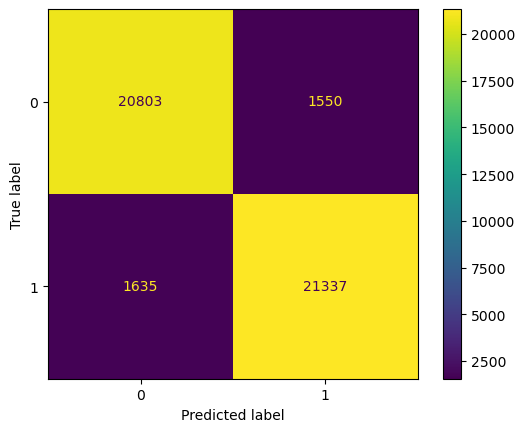

In [35]:
cm = confusion_matrix(y_pred,y_train)
ConfusionMatrixDisplay(cm).plot()

In [36]:
f1_score(y_pred,y_train)

0.9305479840380295

In [37]:
recall_score(y_pred,y_train)

0.9288263973532996

In [38]:
precision_score(y_pred,y_train)

0.932275964521344

In [40]:
accuracy_score(y_pred,y_train)

0.9297297297297298

In [45]:
xgboost1 = XGBClassifier().fit(X_train_ss,y_train)

In [47]:
xgboost1.score(X_train_ss,y_train)

0.9297297297297298

In [49]:
pd.DataFrame(y_train).value_counts(normalize=True)

popularity
1             0.504953
0             0.495047
dtype: float64

### The Over night grid search

In [14]:
X_rem = vect_rem.drop(columns=['track_id', 'album_name', 'artists', 'track_name', 'track_genre',
       'href', 'preview_url','popularity'])
y_rem = vect_rem['popularity']

In [19]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])


# parameters
params = {
    #'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.3,0.4,0.5],
    'xgb__n_estimators': [50,100],
    'xgb__gamma':[0, 0.25, 0.5],
    'xgb__subsample': [0.5, 0.7, 0.9],
   # 'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('XGBoost_grid_1.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [20]:
grid.best_score_

0.9135576392719249

In [22]:
grid.best_params_

{'xgb__gamma': 0.25,
 'xgb__learning_rate': 0.5,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.9}

In [23]:
with open('XGBoost_grid_1.pkl', 'rb') as f:
    grid1 = pickle.load(f)

In [25]:
pd.DataFrame(grid1.cv_results_).sort_values(by='rank_test_score',ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__gamma,param_xgb__learning_rate,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,51.896197,0.123639,0.146233,0.002871,0.25,0.5,100,0.9,"{'xgb__gamma': 0.25, 'xgb__learning_rate': 0.5...",0.909653,0.915830,0.910866,0.918036,0.913403,0.913558,0.003090,1
17,50.877209,0.122968,0.146676,0.007536,0,0.5,100,0.9,"{'xgb__gamma': 0, 'xgb__learning_rate': 0.5, '...",0.910976,0.912631,0.912631,0.916161,0.913072,0.913094,0.001692,2
53,43.747298,1.333688,0.111716,0.015874,0.5,0.5,100,0.9,"{'xgb__gamma': 0.5, 'xgb__learning_rate': 0.5,...",0.911638,0.908770,0.909983,0.914617,0.918478,0.912697,0.003493,3
11,50.674839,0.094490,0.142851,0.002291,0,0.4,100,0.9,"{'xgb__gamma': 0, 'xgb__learning_rate': 0.4, '...",0.905902,0.911748,0.908770,0.901269,0.907226,0.906983,0.003458,4
47,51.682108,0.130875,0.151519,0.006324,0.5,0.4,100,0.9,"{'xgb__gamma': 0.5, 'xgb__learning_rate': 0.4,...",0.895201,0.905792,0.908770,0.910535,0.908218,0.905703,0.005466,5
29,58.214558,1.393109,0.149647,0.005244,0.25,0.4,100,0.9,"{'xgb__gamma': 0.25, 'xgb__learning_rate': 0.4...",0.901931,0.902372,0.905902,0.906453,0.908880,0.905108,0.002617,6
52,49.031508,2.022769,0.150764,0.011281,0.5,0.5,100,0.7,"{'xgb__gamma': 0.5, 'xgb__learning_rate': 0.5,...",0.902372,0.908880,0.906674,0.898400,0.901489,0.903563,0.003750,7
16,49.931852,0.167976,0.146911,0.003241,0,0.5,100,0.7,"{'xgb__gamma': 0, 'xgb__learning_rate': 0.5, '...",0.909432,0.901269,0.902592,0.902703,0.899835,0.903166,0.003302,8
28,58.437513,0.189775,0.161323,0.013505,0.25,0.4,100,0.7,"{'xgb__gamma': 0.25, 'xgb__learning_rate': 0.4...",0.895312,0.899614,0.899173,0.906564,0.909101,0.901953,0.005092,9
34,50.811168,0.275493,0.146870,0.003015,0.25,0.5,100,0.7,"{'xgb__gamma': 0.25, 'xgb__learning_rate': 0.5...",0.902813,0.900717,0.905681,0.898952,0.900276,0.901688,0.002351,10


In [24]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])

# parameters
params = {
    #'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.5,0.6,0.7],
    'xgb__n_estimators': [100,150,200],
    'xgb__gamma':[0.2, 0.25, 0.3],
    'xgb__subsample': [0.8, 0.85, 0.9],
   # 'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('XGBoost_grid_2.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [25]:
grid.best_score_

0.9245670159955874

In [26]:
grid.best_params_

{'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.5,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.9}

In [27]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])

# parameters
params = {
    #'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.45,0.5,0.55],
    'xgb__n_estimators': [200,250,300],
    'xgb__gamma':[0.15, 0.2],
    'xgb__subsample': [0.7, 0.8, 0.9],
   # 'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('XGBoost_grid_3.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [30]:
grid.best_score_

0.9266850523993382

In [32]:
grid.best_params_

{'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.45,
 'xgb__n_estimators': 250,
 'xgb__subsample': 0.9}

In [34]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])

# parameters
params = {
    #'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.43,0.45,0.47],
    'xgb__n_estimators': [225,250,375],
    'xgb__gamma':[0.2],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('XGBoost_grid_4.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [35]:
grid.best_score_

0.9269939327082184

In [36]:
grid.best_params_

{'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.43,
 'xgb__min_child_weight': 0.5,
 'xgb__n_estimators': 375,
 'xgb__subsample': 0.9}

In [15]:
# estimator
estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier()
)])

# parameters
params = {
    'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.42,0.43,0.44],
    'xgb__n_estimators': [100,200],
    'xgb__gamma':[0.2],
    'xgb__subsample': [0.5],
    #'xgb__min_child_weight':[0.5, 0.7, 0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)
    
#writting to pickle
with open('XGBoost_grid_5.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 2/5] END xgb__booster=gbtree, xgb__gamma=0.2, xgb__learning_rate=0.42, xgb__n_estimators=200, xgb__subsample=0.5;, score=0.895 total time= 1.7min
[CV 5/5] END xgb__booster=gbtree, xgb__gamma=0.2, xgb__learning_rate=0.43, xgb__n_estimators=100, xgb__subsample=0.5;, score=0.880 total time=  51.9s
[CV 1/5] END xgb__booster=gbtree, xgb__gamma=0.2, xgb__learning_rate=0.44, xgb__n_estimators=100, xgb__subsample=0.5;, score=0.861 total time=  52.2s
[CV 2/5] END xgb__booster=gbtree, xgb__gamma=0.2, xgb__learning_rate=0.44, xgb__n_estimators=200, xgb__subsample=0.5;, score=0.896 total time= 2.1min
[CV 4/5] END xgb__booster=dart, xgb__gamma=0.2, xgb__learning_rate=0.42, xgb__n_estimators=100, xgb__subsample=0.5;, score=0.879 total time= 3.1min
[CV 2/5] END xgb__booster=dart, xgb__gamma=0.2, xgb__learning_rate=0.43, xgb__n_estimators=100, xgb__subsample=0.5;, score=0.884 total time= 3.0min
[CV 5/5] END xgb__booster=dart, xgb__gamma=

In [16]:
grid.best_score_

0.893811362382791

In [17]:
grid.best_params_

{'xgb__booster': 'gbtree',
 'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.42,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.5}

In [22]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score',ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__booster,param_xgb__gamma,param_xgb__learning_rate,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,102.929858,0.350713,0.250449,0.035657,gbtree,0.2,0.42,200,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.888252,0.894650,0.892554,0.898952,0.894650,0.893811,0.003473,1
5,123.968467,0.181626,0.317292,0.031700,gbtree,0.2,0.44,200,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.885052,0.895753,0.891892,0.892113,0.893436,0.891649,0.003573,2
9,624.516945,6.342649,19.826617,0.852312,dart,0.2,0.43,200,0.5,"{'xgb__booster': 'dart', 'xgb__gamma': 0.2, 'x...",0.893547,0.895422,0.887700,0.886707,0.891671,0.891009,0.003341,3
7,603.283437,4.593616,20.039887,0.196625,dart,0.2,0.42,200,0.5,"{'xgb__booster': 'dart', 'xgb__gamma': 0.2, 'x...",0.895532,0.891561,0.891340,0.889244,0.887259,0.890987,0.002759,4
3,104.919617,3.224885,0.221992,0.008652,gbtree,0.2,0.43,200,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.886045,0.892995,0.886045,0.887590,0.895532,0.889641,0.003899,5
11,430.850147,40.483599,14.103127,1.704345,dart,0.2,0.44,200,0.5,"{'xgb__booster': 'dart', 'xgb__gamma': 0.2, 'x...",0.877992,0.893105,0.890127,0.884611,0.890237,0.887215,0.005369,6
6,180.690429,5.789636,9.473589,0.402032,dart,0.2,0.42,100,0.5,"{'xgb__booster': 'dart', 'xgb__gamma': 0.2, 'x...",0.886045,0.883949,0.885163,0.879316,0.872808,0.881456,0.004907,7
8,175.181155,3.961075,10.343533,0.502256,dart,0.2,0.43,100,0.5,"{'xgb__booster': 'dart', 'xgb__gamma': 0.2, 'x...",0.878764,0.883618,0.874021,0.878875,0.883949,0.879846,0.003664,8
10,188.915078,8.391222,10.348530,0.465483,dart,0.2,0.44,100,0.5,"{'xgb__booster': 'dart', 'xgb__gamma': 0.2, 'x...",0.873249,0.881964,0.876558,0.878875,0.879647,0.878058,0.002961,9
4,55.164224,3.949828,0.181547,0.009087,gbtree,0.2,0.44,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.860563,0.880971,0.882736,0.882074,0.882074,0.877683,0.008579,10


In [33]:

X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=42)
train_acc = []
train_pre = []
train_f1 = []
train_rec = []

val_acc = []
val_pre = []
val_f1 = []
val_rec = []
for x in range(50,350,50):
    XG1 = XGBClassifier(booster='gbtree',learning_rate=0.43,gamma=0.25,subsample=0.6,n_estimators=x).fit(X_train,y_train)
    print(f'n_estimators = {x}')
    y_pred = XG1.predict(X_train)
    print(f'Train Accuracy Score: {accuracy_score(y_pred,y_train)}')
    print(f'Train Recall Score: {recall_score(y_pred,y_train)}')
    print(f'Train Precision Score: {precision_score(y_pred,y_train)}')
    print(f'Train F1 Score: {f1_score(y_pred,y_train)}')
    
    train_acc.append(accuracy_score(y_pred,y_train))
    train_pre.append(recall_score(y_pred,y_train))
    train_f1.append(precision_score(y_pred,y_train))
    train_rec.append(f1_score(y_pred,y_train))
    
    print('\n')
    
    y_pred1 = XG1.predict(X_val)
    print(f'Validation Accuracy Score: {accuracy_score(y_pred1,y_val)}')
    print(f'Validation Recall Score: {recall_score(y_pred1,y_val)}')
    print(f'Validation Precision Score: {precision_score(y_pred1,y_val)}')
    print(f'Validation F1 Score: {f1_score(y_pred1,y_val)}')
    
    val_acc.append(accuracy_score(y_pred1,y_val))
    val_pre.append(recall_score(y_pred1,y_val))
    val_f1.append(precision_score(y_pred1,y_val))
    val_rec.append(f1_score(y_pred1,y_val))
    print('\n')

n_estimators = 50
Train Accuracy Score: 0.890926640926641
Train Recall Score: 0.8835418671799807
Train Precision Score: 0.9029014807933993
Train F1 Score: 0.893116774315596


Validation Accuracy Score: 0.8555984555984556
Validation Recall Score: 0.8513832296804632
Validation Precision Score: 0.8656781508940253
Validation F1 Score: 0.8584711860741702


n_estimators = 100
Train Accuracy Score: 0.9383066740209597
Train Recall Score: 0.9358111774281064
Train Precision Score: 0.9424075187148243
Train F1 Score: 0.9390977648307969


Validation Accuracy Score: 0.8924434638720353
Validation Recall Score: 0.8898725977110775
Validation Precision Score: 0.8986044483209769
Validation F1 Score: 0.8942172073342736


n_estimators = 150
Train Accuracy Score: 0.9594870380584666
Train Recall Score: 0.9610496329571601
Train Precision Score: 0.9585814982787826
Train F1 Score: 0.9598139789358501


Validation Accuracy Score: 0.9030336458907887
Validation Recall Score: 0.9042529989094874
Validation Precision 

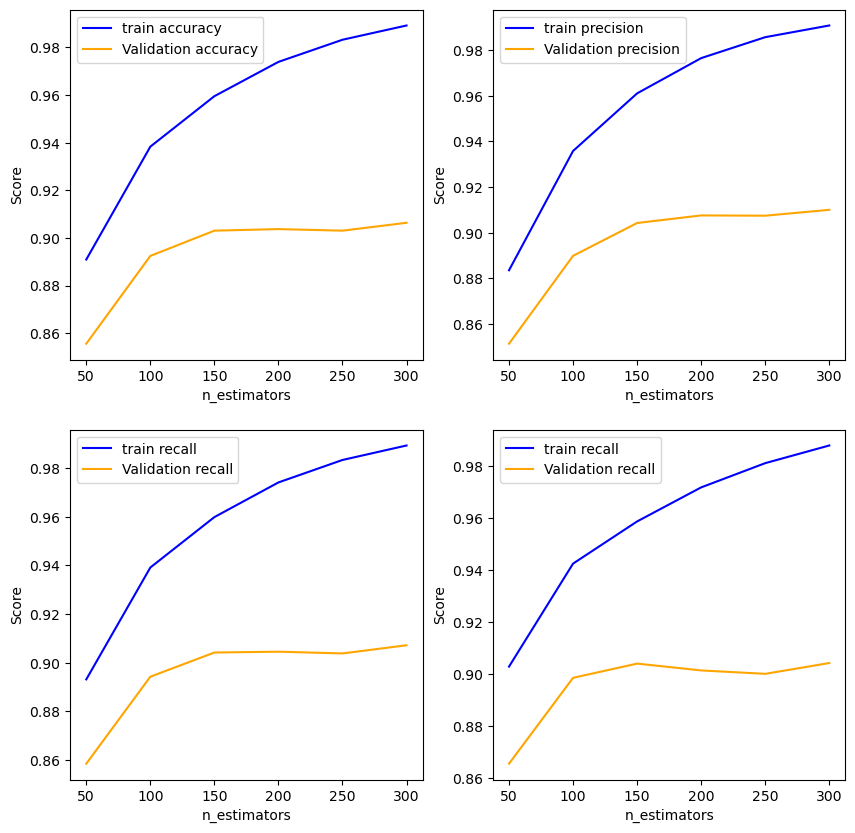

In [44]:
#Exploring the effect of n_estimators on overfitting
plt.subplots(2,2,figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(range(50,350,50),train_acc,label='train accuracy',color='blue')
plt.plot(range(50,350,50),val_acc,label='Validation accuracy',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,2)
plt.plot(range(50,350,50),train_pre,label='train precision',color='blue')
plt.plot(range(50,350,50),val_pre,label='Validation precision',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,3)
plt.plot(range(50,350,50),train_rec,label='train recall',color='blue')
plt.plot(range(50,350,50),val_rec,label='Validation recall',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,4)
plt.plot(range(50,350,50),train_f1,label='train f1 score',color='blue')
plt.plot(range(50,350,50),val_f1,label='Validation f1 score',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')

plt.show()


In [61]:

X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=42)
train_acc = []
train_pre = []
train_f1 = []
train_rec = []

val_acc = []
val_pre = []
val_f1 = []
val_rec = []
for x in range(10,100,10):
    XG1 = XGBClassifier(booster='gbtree',learning_rate=0.43,gamma=0.25,subsample=0.6,n_estimators=x).fit(X_train,y_train)
    print(f'n_estimators = {x}')
    y_pred = XG1.predict(X_train)
    print(f'Train Accuracy Score: {accuracy_score(y_pred,y_train)}')
    print(f'Train Recall Score: {recall_score(y_pred,y_train)}')
    print(f'Train Precision Score: {precision_score(y_pred,y_train)}')
    print(f'Train F1 Score: {f1_score(y_pred,y_train)}')
    
    train_acc.append(accuracy_score(y_pred,y_train))
    train_pre.append(recall_score(y_pred,y_train))
    train_f1.append(precision_score(y_pred,y_train))
    train_rec.append(f1_score(y_pred,y_train))
    
    print('\n')
    
    y_pred1 = XG1.predict(X_val)
    print(f'Validation Accuracy Score: {accuracy_score(y_pred1,y_val)}')
    print(f'Validation Recall Score: {recall_score(y_pred1,y_val)}')
    print(f'Validation Precision Score: {precision_score(y_pred1,y_val)}')
    print(f'Validation F1 Score: {f1_score(y_pred1,y_val)}')
    
    val_acc.append(accuracy_score(y_pred1,y_val))
    val_pre.append(recall_score(y_pred1,y_val))
    val_f1.append(precision_score(y_pred1,y_val))
    val_rec.append(f1_score(y_pred1,y_val))
    print('\n')

n_estimators = 10
Train Accuracy Score: 0.6960011031439602
Train Recall Score: 0.6792434242931731
Train Precision Score: 0.7535107371181903
Train F1 Score: 0.7144522446441985


Validation Accuracy Score: 0.6732487589630447
Validation Recall Score: 0.6607284243863817
Validation Precision Score: 0.7278674225904928
Validation F1 Score: 0.6926748288026561


n_estimators = 20
Train Accuracy Score: 0.7616657473800331
Train Recall Score: 0.7467681774053446
Train Precision Score: 0.7985902409704387
Train F1 Score: 0.7718103084072666


Validation Accuracy Score: 0.7325979040264755
Validation Recall Score: 0.7240878938640133
Validation Precision Score: 0.7616659398168338
Validation F1 Score: 0.7424017003188098


n_estimators = 30
Train Accuracy Score: 0.8206012134583563
Train Recall Score: 0.8081182739525651
Train Precision Score: 0.8452543576853724
Train F1 Score: 0.8262692626125043


Validation Accuracy Score: 0.7891891891891892
Validation Recall Score: 0.783068783068783
Validation Precision S

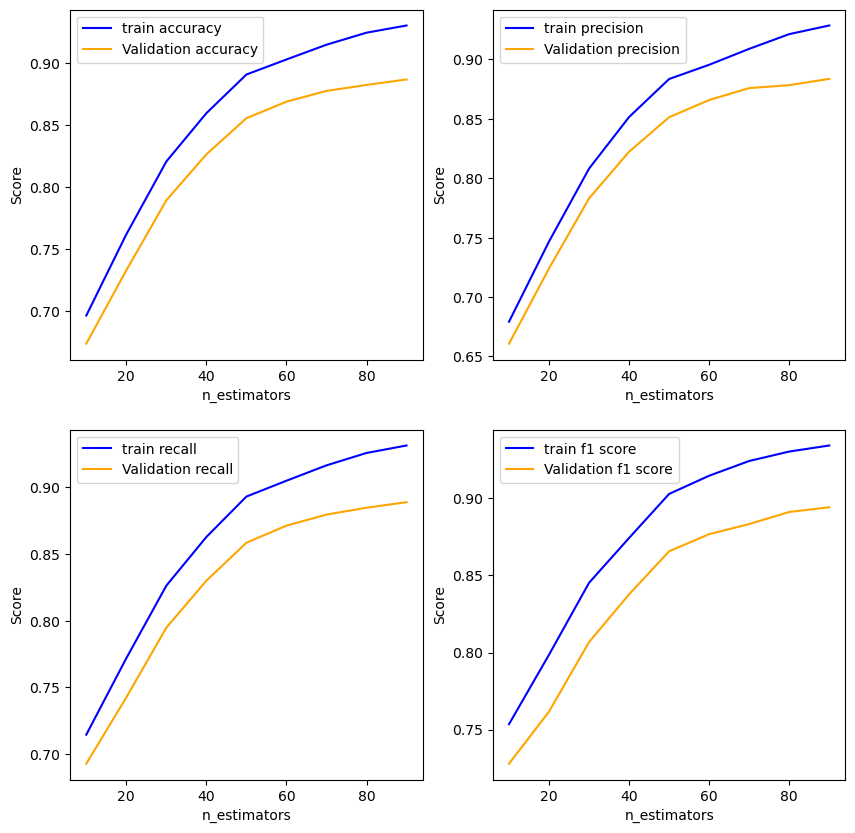

In [62]:
#Exploring the effect of n_estimators on overfitting
plt.subplots(2,2,figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(range(10,100,10),train_acc,label='train accuracy',color='blue')
plt.plot(range(10,100,10),val_acc,label='Validation accuracy',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,2)
plt.plot(range(10,100,10),train_pre,label='train precision',color='blue')
plt.plot(range(10,100,10),val_pre,label='Validation precision',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,3)
plt.plot(range(10,100,10),train_rec,label='train recall',color='blue')
plt.plot(range(10,100,10),val_rec,label='Validation recall',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,4)
plt.plot(range(10,100,10),train_f1,label='train f1 score',color='blue')
plt.plot(range(10,100,10),val_f1,label='Validation f1 score',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')

plt.show()


In [63]:
acc_diff = []
for x in range(len(train_acc)):
    acc_diff.append(train_acc[x] - val_acc[x])

pd.DataFrame({'n_estimators':range(10,100,10),
              'train acc':train_acc,'val acc':val_acc,
              'accuracy diffrence':acc_diff})

,n_estimators,accuracy diffrence
0,10,0.022752
1,20,0.029068
2,30,0.031412
3,40,0.033287
4,50,0.035328
5,60,0.034142
6,70,0.037369
7,80,0.042250
8,90,0.043657


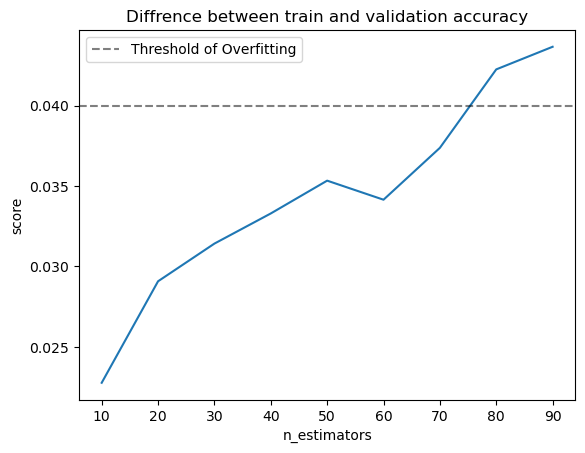

In [70]:
plt.figure()

plt.plot(range(10,100,10), acc_diff)
plt.title('Diffrence between train and validation accuracy')
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.axhline(0.04, linestyle='--',color='black',label='Threshold of Overfitting', alpha=0.5)
plt.legend()

plt.show()

In [45]:
# estimator
estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier()
)])

# parameters
params = {
    'xgb__booster': ['gbtree'],
    'xgb__learning_rate':[0.2,0.4,0.6],
    'xgb__n_estimators': [50,75,100],
    'xgb__gamma':[0.2,0.25,0.3],
    'xgb__subsample': [0.5],
    'xgb__min_child_weight':[0.5, 1,5,10]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_rem, y_rem)
    
#writting to pickle
with open('XGBoost_grid_6.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [46]:
grid.best_score_

0.8783452840595697

In [47]:
grid.best_params_

{'xgb__booster': 'gbtree',
 'xgb__gamma': 0.25,
 'xgb__learning_rate': 0.4,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.5}

In [49]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score',ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__booster,param_xgb__gamma,param_xgb__learning_rate,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
53,49.718121,0.030146,0.164026,0.006544,gbtree,0.25,0.4,1,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.25,...",0.874242,0.881853,0.876889,0.885383,0.873359,0.878345,0.004597,1
86,50.028678,0.169291,0.163386,0.006373,gbtree,0.3,0.4,0.5,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.3, ...",0.868395,0.867181,0.887259,0.883067,0.880750,0.877330,0.008075,2
89,49.703447,0.166600,0.160996,0.004109,gbtree,0.3,0.4,1,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.3, ...",0.864203,0.886045,0.877882,0.879868,0.877882,0.877176,0.007144,3
50,50.093948,0.181275,0.163336,0.011146,gbtree,0.25,0.4,0.5,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.25,...",0.871815,0.871484,0.878103,0.881191,0.881081,0.876735,0.004299,4
14,59.414940,1.643178,0.203993,0.016273,gbtree,0.2,0.4,0.5,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.865968,0.882846,0.869498,0.875345,0.881412,0.875014,0.006552,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,26.166779,0.812756,0.142318,0.008281,gbtree,0.25,0.2,5,50,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.25,...",0.770215,0.757860,0.782570,0.766795,0.767237,0.768935,0.007971,104
6,25.275581,0.076309,0.144655,0.004331,gbtree,0.2,0.2,5,50,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.770215,0.757860,0.770325,0.766795,0.767126,0.766464,0.004551,105
9,27.746300,0.390985,0.173668,0.024243,gbtree,0.2,0.2,10,50,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.740430,0.749035,0.750248,0.737672,0.754992,0.746475,0.006440,106
45,25.161499,0.031552,0.137339,0.006182,gbtree,0.25,0.2,10,50,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.25,...",0.740430,0.748704,0.750248,0.737672,0.755102,0.746431,0.006444,107


In [58]:
from sklearn.linear_model import LogisticRegression
# estimator
estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=10000))
])

# parameters
params = {
    'logit__solver': ['lbfgs' ,'sag', 'saga'],
    'logit__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
   # 'logit__gamma': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.9],
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_rem, y_rem)
    
#writting to pickle
with open('Logit_grid_1.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [59]:
grid.best_score_

0.6139216767788197

In [60]:
grid.best_params_

{'logit__C': 0.5, 'logit__solver': 'sag'}

In [74]:
# estimator
estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier()
)])

# parameters
params = {
    'xgb__booster': ['gbtree'],
    'xgb__learning_rate':[0.3,0.4,0.5],
    'xgb__n_estimators': [70],
    'xgb__gamma':[0.23,0.25,0.27],
    'xgb__subsample': [0.5],
    'xgb__min_child_weight':[0.5, 0.75, 1]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_rem, y_rem)
    
#writting to pickle
with open('XGBoost_grid_7.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [75]:
grid.best_score_

0.8673579702151131

In [76]:
grid.best_params_

{'xgb__booster': 'gbtree',
 'xgb__gamma': 0.27,
 'xgb__learning_rate': 0.5,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 70,
 'xgb__subsample': 0.5}

In [77]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score',ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__booster,param_xgb__gamma,param_xgb__learning_rate,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,32.714467,0.128123,0.118486,0.009130,gbtree,0.27,0.5,1,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.27,...",0.859459,0.857694,0.878764,0.868285,0.872587,0.867358,0.007926,1
17,36.131855,0.180548,0.153994,0.005765,gbtree,0.25,0.5,1,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.25,...",0.856040,0.860563,0.873249,0.869829,0.869277,0.865792,0.006427,2
8,36.241225,0.048454,0.185108,0.016963,gbtree,0.23,0.5,1,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.23,...",0.859680,0.866740,0.866409,0.869498,0.865747,0.865615,0.003232,3
22,35.789471,0.024658,0.153529,0.004794,gbtree,0.27,0.4,0.75,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.27,...",0.852068,0.864093,0.870050,0.865085,0.866078,0.863475,0.006051,4
24,36.034271,0.082944,0.154343,0.007443,gbtree,0.27,0.5,0.5,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.27,...",0.855929,0.864755,0.861886,0.864975,0.867512,0.863012,0.003964,5
25,34.769849,1.550640,0.151977,0.007211,gbtree,0.27,0.5,0.75,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.27,...",0.855709,0.860232,0.857033,0.870601,0.868395,0.862394,0.006025,6
6,37.399255,1.251525,0.171004,0.005358,gbtree,0.23,0.5,0.5,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.23,...",0.864424,0.861666,0.857033,0.861666,0.866630,0.862284,0.003219,7
13,36.143464,0.072498,0.159644,0.007059,gbtree,0.25,0.4,0.75,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.25,...",0.845119,0.855929,0.868064,0.868064,0.866630,0.860761,0.009046,8
14,36.334950,0.213674,0.165908,0.014079,gbtree,0.25,0.4,1,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.25,...",0.856260,0.868726,0.862659,0.862879,0.853061,0.860717,0.005497,9
4,37.943421,0.936118,0.270060,0.060212,gbtree,0.23,0.4,0.75,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.23,...",0.861886,0.853172,0.868064,0.866409,0.853723,0.860651,0.006222,10


In [78]:

X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=42)
train_acc = []
train_pre = []
train_f1 = []
train_rec = []

val_acc = []
val_pre = []
val_f1 = []
val_rec = []
for x in range(50,150,10):
    XG1 = XGBClassifier(booster='gbtree',learning_rate=0.45,gamma=0.27,subsample=0.5,n_estimators=x).fit(X_train,y_train)
    print(f'n_estimators = {x}')
    y_pred = XG1.predict(X_train)
    print(f'Train Accuracy Score: {accuracy_score(y_pred,y_train)}')
    print(f'Train Recall Score: {recall_score(y_pred,y_train)}')
    print(f'Train Precision Score: {precision_score(y_pred,y_train)}')
    print(f'Train F1 Score: {f1_score(y_pred,y_train)}')
    
    train_acc.append(accuracy_score(y_pred,y_train))
    train_pre.append(recall_score(y_pred,y_train))
    train_f1.append(precision_score(y_pred,y_train))
    train_rec.append(f1_score(y_pred,y_train))
    
    print('\n')
    
    y_pred1 = XG1.predict(X_val)
    print(f'Validation Accuracy Score: {accuracy_score(y_pred1,y_val)}')
    print(f'Validation Recall Score: {recall_score(y_pred1,y_val)}')
    print(f'Validation Precision Score: {precision_score(y_pred1,y_val)}')
    print(f'Validation F1 Score: {f1_score(y_pred1,y_val)}')
    
    val_acc.append(accuracy_score(y_pred1,y_val))
    val_pre.append(recall_score(y_pred1,y_val))
    val_f1.append(precision_score(y_pred1,y_val))
    val_rec.append(f1_score(y_pred1,y_val))
    print('\n')

n_estimators = 50
Train Accuracy Score: 0.8882515168229453
Train Recall Score: 0.8806432654805791
Train Precision Score: 0.9006611660564996
Train F1 Score: 0.8905397374250364


Validation Accuracy Score: 0.8583563154991727
Validation Recall Score: 0.8545962199312714
Validation Precision Score: 0.8676406454426515
Validation F1 Score: 0.8610690326769098


n_estimators = 60
Train Accuracy Score: 0.9080253723110866
Train Recall Score: 0.9073932926829268
Train Precision Score: 0.9107152614611224
Train F1 Score: 0.9090512421936785


Validation Accuracy Score: 0.875896304467733
Validation Recall Score: 0.8761138882851554
Validation Precision Score: 0.8789795028347144
Validation F1 Score: 0.877544356155437


n_estimators = 70
Train Accuracy Score: 0.9169056811913955
Train Recall Score: 0.9173400305743612
Train Precision Score: 0.9180919075460358
Train F1 Score: 0.9177158150585794


Validation Accuracy Score: 0.8809707666850524
Validation Recall Score: 0.8842866535174227
Validation Precision Sc

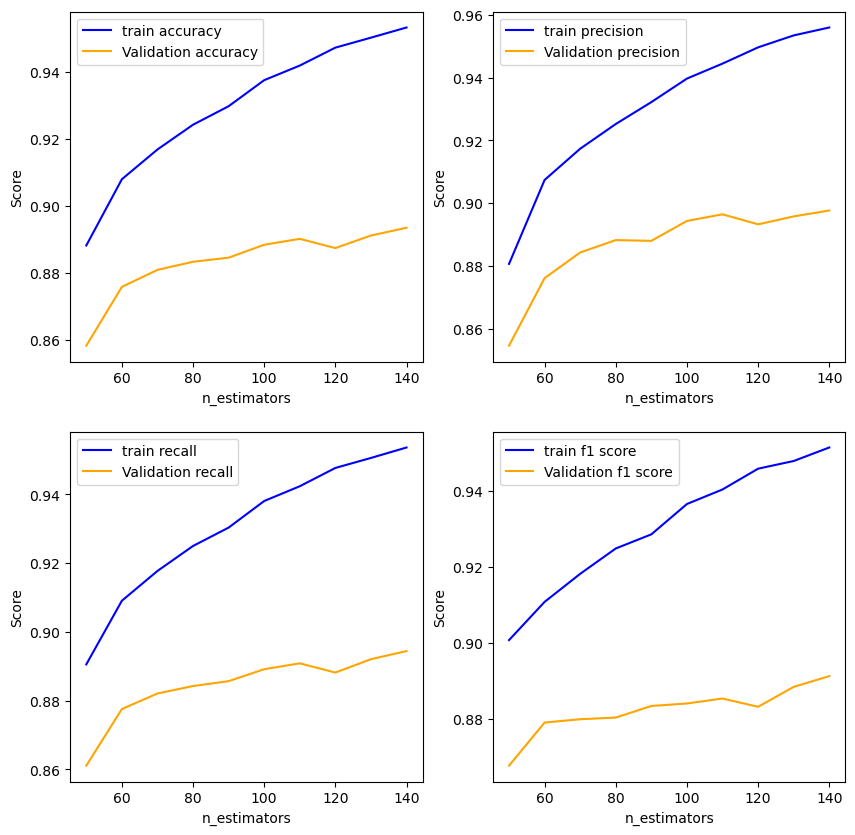

In [79]:
#Exploring the effect of n_estimators on overfitting
plt.subplots(2,2,figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(range(50,150,10),train_acc,label='train accuracy',color='blue')
plt.plot(range(50,150,10),val_acc,label='Validation accuracy',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,2)
plt.plot(range(50,150,10),train_pre,label='train precision',color='blue')
plt.plot(range(50,150,10),val_pre,label='Validation precision',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,3)
plt.plot(range(50,150,10),train_rec,label='train recall',color='blue')
plt.plot(range(50,150,10),val_rec,label='Validation recall',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')


plt.subplot(2,2,4)
plt.plot(range(50,150,10),train_f1,label='train f1 score',color='blue')
plt.plot(range(50,150,10),val_f1,label='Validation f1 score',color='orange')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Score')

plt.show()


In [80]:
acc_diff = []
for x in range(len(train_acc)):
    acc_diff.append(train_acc[x] - val_acc[x])

pd.DataFrame({'n_estimators':range(50,150,10),
              'train acc':train_acc,'val acc':val_acc,
              'accuracy diffrence':acc_diff})

,n_estimators,train acc,val acc,accuracy diffrence
0,50,0.888252,0.858356,0.029895
1,60,0.908025,0.875896,0.032129
2,70,0.916906,0.880971,0.035935
3,80,0.924297,0.883398,0.040899
4,90,0.929812,0.884611,0.045201
5,100,0.937590,0.888472,0.049117
6,110,0.941947,0.890237,0.051710
7,120,0.947297,0.887479,0.059818
8,130,0.950276,0.891230,0.059046
9,140,0.953309,0.893547,0.059763


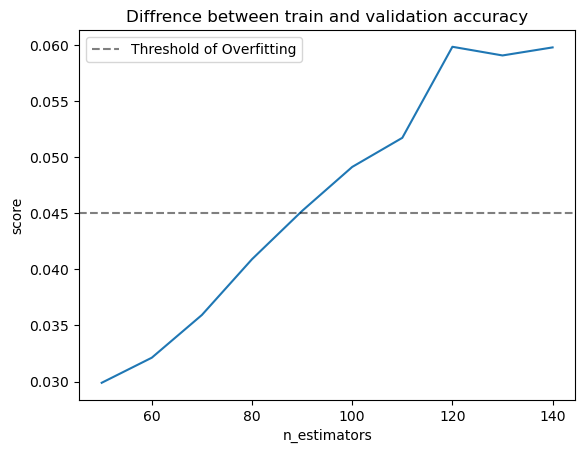

In [83]:
plt.figure()

plt.plot(range(50,150,10), acc_diff)
plt.title('Diffrence between train and validation accuracy')
plt.ylabel('score')
plt.xlabel('n_estimators')
plt.axhline(0.045, linestyle='--',color='black',label='Threshold of Overfitting', alpha=0.5)
plt.legend()

plt.show()